<a href="https://colab.research.google.com/github/prashun07/Malaria_cell_detection/blob/main/Pytorch_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Adding some Essentials to connect notebook with  jovian.ai

In [77]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1znGbjklEI3Lf_a_dC5QHilBSWHsbqFOJ')

In [78]:
!pip install jovian --upgrade --quiet

In [79]:
import jovian

##About the Dataset:
###Name: **Malaria Cell Images Dataset**
It contains cell images for Detecting Malaria.

dataset link:https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

**Malaria** is a life-threatening disease caused by **parasites** that are transmitted to people through the bites of infected female **Anopheles** mosquitoes.
In 2019, there were an estimated 229 million cases of malaria worldwide.
The estimated number of malaria deaths stood at 409,000 in 2019.
We are Going to use Deep Learning to solve the problem and to help our Doctors to Save humans by detecting Image Cells that contain Malaria or not!

##Before,I move further let me first summarize the steps we will explore to reach the solution.
1.Dowload dataset into colab.

2.import and Explore it using pytorch

3.Prepare it for nueral network and load on the GPU

4.Prepare Training Utilites

5.Prepare the model.

6.Train the model.

7.Record the Results.

8.Test accuracy of Individual Images.

# **Download** **Dataset**

In [5]:
#These are some basic Utilites we will need.
import os #To handle dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder #to load data from folder
from torch.utils.data import DataLoader 
import torchvision.transforms as tt #to tansform image into tensors
from torch.utils.data import random_split #for spliting dataset into train and validation set
from torchvision.utils import make_grid 

#to draw images in notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#check Pytorch documentation for more details.

####I am going to use opendatasets method of jovian to download image from url. 

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

dataset link:https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In below cell, You need kaggle username and password because we are downloading dataset from kaggle.
You can also use kaggle.json file after uploading it in colab files.
to get kaggle.json file:
open your kaggle account->account->create new api
you will get it.
Now lets download our dataset.

In [10]:
dataset_url='https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria'
od.download(dataset_url)

  2%|▏         | 12.0M/675M [00:00<00:05, 124MB/s]

100%|██████████| 675M/675M [00:08<00:00, 84.5MB/s]


# **Explore Dataset**

We are done with downloading so lets explore what is inside the downloaded files.


In [11]:
data_dir='/content/cell-images-for-detecting-malaria'

In [12]:
os.listdir(data_dir) 

['cell_images']

In [13]:
os.listdir(data_dir+'/cell_images')

['Parasitized', 'Uninfected', 'cell_images']

In the above output you can see that we get an Extra 'cell_images' file which is copy of main folder 'cell_images'.so,we need to remove that using shutil.rmtree.
visit for more:https://www.geeksforgeeks.org/delete-an-entire-directory-tree-using-python-shutil-rmtree-method/#:~:text=files%20and%20directories.-,shutil.,symbolic%20link%20to%20a%20directory).&text=Parameters%3A,object%20representing%20a%20file%20path.


In [14]:
import shutil
shutil.rmtree(data_dir+'/cell_images/cell_images')

In [15]:
os.listdir(data_dir+'/cell_images')

['Parasitized', 'Uninfected']

###We cleared errors in dataset.now,import it using ImageFolder.


In [16]:
dataset=ImageFolder(data_dir+'/cell_images')

lets,see the no. of Images in dataset

In [17]:
len(dataset)

27558

In [18]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=142x148 at 0x7F4BAAFE6358>, 0)

Dataset contains  PIL image and labels along.

In [19]:
dataset.classes

['Parasitized', 'Uninfected']

###Our Dataset contains Two labels (Parasitized and Uninfected.
so before we move further lets see some of the images.

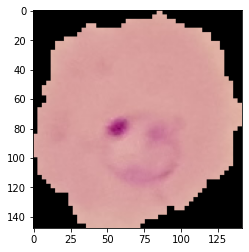

In [20]:
img,label=dataset[0]
plt.imshow(img)

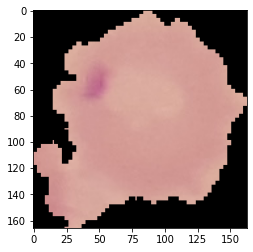

In [21]:
img,label=dataset[50]
plt.imshow(img)

In [22]:
data_dir=data_dir+'/cell_images'

In [23]:
for cls in os.listdir(data_dir):
  print(cls,':',len(os.listdir(data_dir+'/'+cls)))



Parasitized : 13780
Uninfected : 13780


Dataset is Well Balanced because both the label have equal sets of images.

In [25]:
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64),#Resize is used for resizing image
                                         tt.RandomCrop(64),#Crop image randomly
                                         tt.ToTensor()]))#convert PIL image into tensor
                                         

we transfromed our dataset into tensors and also used randomcrop and resize function to make dataset more accurate.
Now,print some images.

0


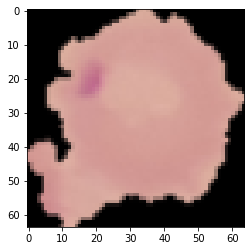

In [27]:
img,label=dataset[50]
plt.imshow(img.permute(1,2,0))
print(label)

0


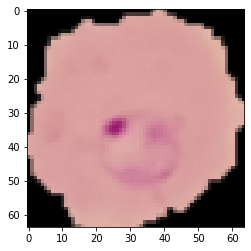

In [28]:
img,label=dataset[0]
plt.imshow(img.permute(1,2,0))
print(label)

1


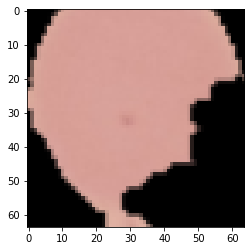

In [29]:
img,label=dataset[13800]
plt.imshow(img.permute(1,2,0))
print(label)

label 0 means Parasitized.if you look Properly 1st and 2nd images have something dark pink there but the 3rd image have label 1 means Uninfected and it does not have that colored pixel.

In [31]:
#To Divide dataset into train set and validation set 
#taking 10% of data as validation set
val_per=0.1
val_size=int(val_per*len(dataset))
train_size=len(dataset)-val_size
train_size,val_size

(24803, 2755)

In [32]:
#random split used to split dataset
train_ds,valid_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

(24803, 2755)

In [33]:
#Now,Lets take batch size=128 and load data into batches
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

its time to make grid.

In [34]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=18).permute(1, 2, 0))
        break

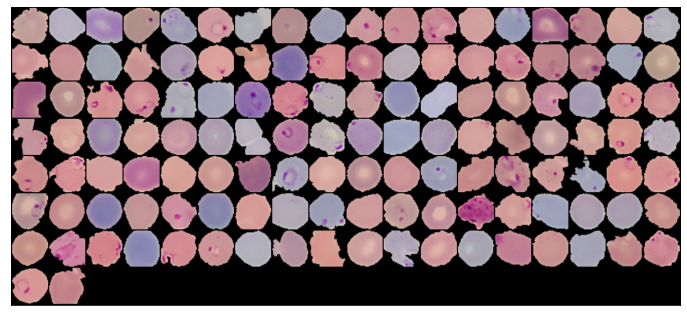

In [35]:
show_batch(train_dl)

# Utilites to load data into GPU

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
#Load data into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# **Training Utilites**

In [39]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# **Creating Model**

In [41]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [42]:
model = to_device(ResNet9(3, 2), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Lets pass one batch into the model and see how it is going 

In [43]:
for batch in train_dl:
  images,labels=batch
  print('image shape',images.shape)
  print(images.device)
  preds=model(images)
  print('preds shape:',preds.shape)
  break

image shape torch.Size([128, 3, 64, 64])
cuda:0
preds shape: torch.Size([128, 2])


In [80]:
project_name='pytorch_project07'
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pkjhamkt/pytorch-project07


'https://jovian.ai/pkjhamkt/pytorch-project07'

##**Training**

In [45]:
history=[evaluate(model,val_dl)]
history

[{'val_acc': 0.5057382583618164, 'val_loss': 0.693556547164917}]

In [46]:
history+=fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4364, val_loss: 0.1584, val_acc: 0.9479
Epoch [1], train_loss: 0.1762, val_loss: 0.1407, val_acc: 0.9535
Epoch [2], train_loss: 0.1504, val_loss: 0.1413, val_acc: 0.9539
Epoch [3], train_loss: 0.1400, val_loss: 0.1414, val_acc: 0.9523
Epoch [4], train_loss: 0.1378, val_loss: 0.1213, val_acc: 0.9580


In [47]:
history+=fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.1599, val_loss: 0.1231, val_acc: 0.9605
Epoch [1], train_loss: 0.1403, val_loss: 0.1460, val_acc: 0.9513
Epoch [2], train_loss: 0.1308, val_loss: 0.1684, val_acc: 0.9436
Epoch [3], train_loss: 0.1298, val_loss: 0.1159, val_acc: 0.9564
Epoch [4], train_loss: 0.1238, val_loss: 0.1149, val_acc: 0.9574


In [48]:
history+=fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.1038, val_loss: 0.1083, val_acc: 0.9597
Epoch [1], train_loss: 0.0991, val_loss: 0.1059, val_acc: 0.9640
Epoch [2], train_loss: 0.0949, val_loss: 0.1109, val_acc: 0.9600
Epoch [3], train_loss: 0.0931, val_loss: 0.1073, val_acc: 0.9618
Epoch [4], train_loss: 0.0892, val_loss: 0.1009, val_acc: 0.9664


We got a validation accuracy of 96%+ which is good.
so,now see how our model is doing by ploting some graphs.

In [49]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

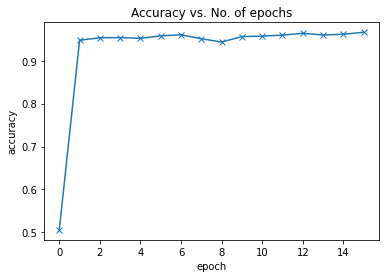

In [50]:
plot_accuracies(history)

we can see that even after 1st epoch accuracy started flattening.Lets check is it overfit or not.

In [52]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

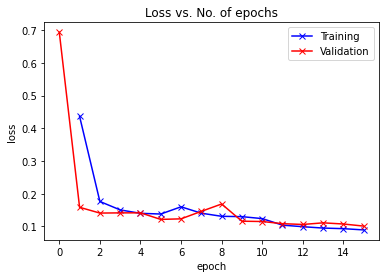

In [53]:
plot_losses(history)

Training loss and Validation loss is near to each and still decreasing upto 11 epochs. 

##Record the result

In [54]:
jovian.log_hyperparams(batch_size=128,
                       arch='ResNet9',
                       epochs=[5,5,5],
                       lrs=[0.001,0.001,0.0001],
                       opt=['Adam','Adam','Adam'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [73]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pkjhamkt/pytorch-project07


'https://jovian.ai/pkjhamkt/pytorch-project07'

##Test with individual Images

In [56]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Target: Parasitized
Predicted: Parasitized


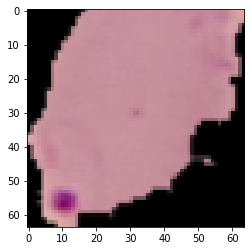

In [57]:
img,label=valid_ds[0]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Parasitized
Predicted: Parasitized


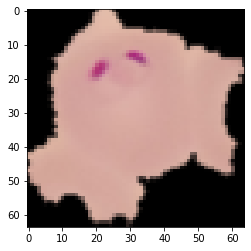

In [58]:
img,label=valid_ds[10]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Uninfected
Predicted: Uninfected


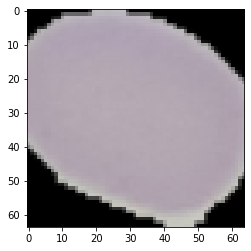

In [59]:
img,label=valid_ds[100]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Parasitized
Predicted: Parasitized


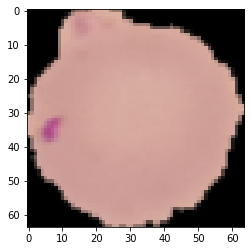

In [60]:
img,label=valid_ds[200]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Uninfected
Predicted: Uninfected


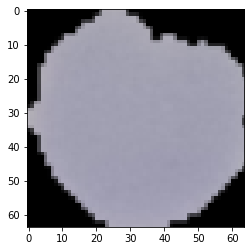

In [61]:
img,label=valid_ds[1000]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Parasitized
Predicted: Parasitized


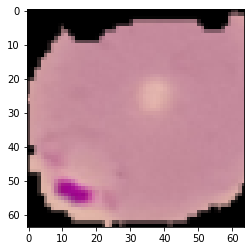

In [64]:
img,label=valid_ds[2000]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Parasitized
Predicted: Parasitized


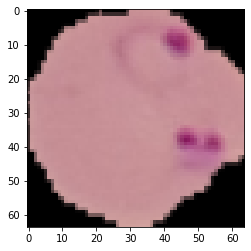

In [65]:
img,label=valid_ds[1050]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Parasitized
Predicted: Parasitized


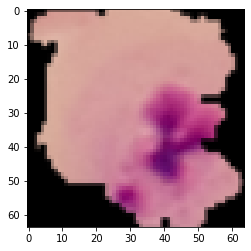

In [67]:
img,label=valid_ds[2005]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

Target: Uninfected
Predicted: Uninfected


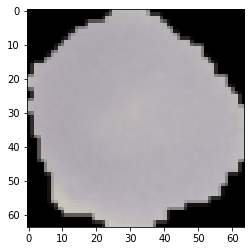

In [68]:
img,label=valid_ds[60]
preds=predict_image(img,model,dataset.classes)
plt.imshow(img.permute(1,2,0))
print('Target:',dataset.classes[label])
print('Predicted:',preds)

After Checking Individual images randomly we found that our model is performing very well.

In [81]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pkjhamkt/pytorch-project07


'https://jovian.ai/pkjhamkt/pytorch-project07'

In [82]:
torch.save(model.state_dict(), 'Malaria_cell.pth')

In [83]:
jovian.commit(project=project_name,
              outputs=['Malaria_cell.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pkjhamkt/pytorch-project07


'https://jovian.ai/pkjhamkt/pytorch-project07'